# Imports

In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point as cyclic
import cftime
# import nc_time_axis
import datetime

# import time
# import glob, os
# import math
import copy

from sklearn.metrics import r2_score
import scipy.interpolate as scp
from scipy.stats import skew
from scipy.ndimage.filters import gaussian_filter

import eofs
from eofs.xarray import Eof

%load_ext autoreload
%autoreload 2

In [2]:
from defs import EOF_analysis, lowess, MT_spectrum, Confidence_intervals, change_lons, contourlines, lat_ticks, lon_ticks, varfs, compute_SLP_eofs, eofs_to_nc, varperc, calc_siva, scatter_hist
# from defs import change_lons, contourlines, lat_ticks, lon_ticks, varfs, compute_SLP_eofs, eofs_to_nc, varperc

# Load data and grid

In [3]:
ds1 = xr.open_dataset('200years/annular_data/E280p_PV_200jan.nc');
ds2 = xr.open_dataset('200years/annular_data/E560p_PV_200jan.nc');
ds3 = xr.open_dataset('200years/annular_data/Eoi280_PV_200jan.nc');

dsp1 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob1.nc')
dsp2 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob2.nc')
dsp3 = xr.open_dataset('200years/annular_data/plevs/u_pv_glob3.nc')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [4]:
dsgrid = xr.open_dataset(f'PI_Plio_clim/data/atm/b.PI_1pic_f19g16_NESSC_control.cam2.h0.climatology.years_3000-3050.nc')

grid = dsgrid.gw.isel(record=0)
x = np.empty([len(grid), len(ds1.lon)])
for i in range(144): x[:,i] = grid.values/len(ds1.lon);
gridweights = xr.DataArray(x, [("lat", grid.lat.values), ("lon", ds1.lon.values)])

In [5]:
## Load Eoi400 data

ds4 = xr.open_dataset('200years/annular_data/Eoi400_200y_atm.nc')
ds4 = ds4.isel(time=ds4.groupby('time.month').groups[1]);

## Landfracs

In [6]:
# Get landfracs and add a cyclic point for contour plotting
# define clevel as the contour level on which to plot the landfrac data

clevel = [0.37, 0.37, 0.18]

dsx=ds1.isel(time=0); lf1, lf_lons = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)
dsx=ds2.isel(time=0); lf2, _ = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)
dsx=ds3.isel(time=0); lf3, _ = cartopy.util.add_cyclic_point(dsx.lfrac, coord=dsx.lfrac.lon)

exp = [1, 2, 3]; 
lf = xr.DataArray(data = np.array([lf1, lf2, lf3]), dims = ["exp", "lat", "lon"], coords = dict(lat = ("lat", dsx.lfrac.lat), lon = ("lon", lf_lons), exp = ("exp", exp)), attrs=dict(description = "landfrac with cyclic point"))
lf_levels = xr.DataArray(data = clevel, dims = "exp", coords = dict(exp = ("exp", exp)), attrs = dict(description = "landfrac contour level"))

lfracs = lf.to_dataset(name = "landfrac")
lfracs["clevel"] = lf_levels

In [7]:
## lfrac data 

lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

lfnh = lfracs.sel(lat = slice(0,85));
lfh = lfracs.sel(lat = slice(lats[0], lats[1])); 
lfp = lfh.sel(lon = slice(nplons[0], nplons[1])); 
lfa = change_lons(copy.copy(lfh)).sel(lon = slice(nalons[0], nalons[1]))


# Calculate and reload SLP EOFs

In [516]:
lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];
nmodes = 2;
lowess_filter = True;
rmlen = 50;

eofsh1, sdnh1 = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa1, _ = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp1, _ = compute_SLP_eofs(ds1.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)

eofsh2, sdnh2 = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa2, _ = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp2, _ = compute_SLP_eofs(ds2.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'PI', lowess_filter = lowess_filter, rmlen = rmlen)

eofsh3, sdnh3 = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NH', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)
eofsa3, _ = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NA', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)
eofsp3, _ = compute_SLP_eofs(ds3.SLP, gridweights=gridweights, nmodes = nmodes, lats = lats, sector = 'NP', sim = 'Plio', lowess_filter = lowess_filter, rmlen = rmlen)

nh1 = ds1.SLP.sel(lat = slice(lats[0], lats[1]));
nh2 = ds2.SLP.sel(lat = slice(lats[0], lats[1]));
nh3 = ds3.SLP.sel(lat = slice(lats[0], lats[1]));



In [590]:
## save eofs

folder = '200years/annular_data/eofs/'

sdnh1.to_dataset(name = 'sdnh1')
eofs_to_nc(eofsh1, 'SLP EOFs and PCs', 'E280p', 'Northern Hemisphere', folder, 'SLP_EOFs_NH1')
eofs_to_nc(eofsa1, 'SLP EOFs and PCs', 'E280p', 'North Atlantic',      folder, 'SLP_EOFs_NA1')
eofs_to_nc(eofsp1, 'SLP EOFs and PCs', 'E280p', 'North Pacific',       folder, 'SLP_EOFs_NP1')
eofs_to_nc(sdnh1,  'SLP S.D.',         'E280p', 'Northern Hemisphere', folder, 'SLP_SD_NH1')

sdnh2.to_dataset(name = 'sdnh2')
eofs_to_nc(eofsh2, 'SLP EOFs and PCs', 'E560p', 'Northern Hemisphere', folder, 'SLP_EOFs_NH2')
eofs_to_nc(eofsa2, 'SLP EOFs and PCs', 'E560p', 'North Atlantic',      folder, 'SLP_EOFs_NA2')
eofs_to_nc(eofsp2, 'SLP EOFs and PCs', 'E560p', 'North Pacific',       folder, 'SLP_EOFs_NP2')
eofs_to_nc(sdnh2,  'SLP S.D.',         'E560p', 'Northern Hemisphere', folder, 'SLP_SD_NH2')

sdnh3.to_dataset(name = 'sdnh3')
eofs_to_nc(eofsh3, 'SLP EOFs and PCs', 'Eoi280', 'Northern Hemisphere', folder, 'sSLP_EOFs_NH3')
eofs_to_nc(eofsa3, 'SLP EOFs and PCs', 'Eoi280', 'North Atlantic',      folder, 'SLP_EOFs_NA3')
eofs_to_nc(eofsp3, 'SLP EOFs and PCs', 'Eoi280', 'North Pacific',       folder, 'SLP_EOFs_NP3')
eofs_to_nc(sdnh3,  'SLP S.D.',         'Eoi280', 'Northern Hemisphere', folder, 'SLP_SD_NH3')

PermissionError: [Errno 13] Permission denied: b'/Users/oldem004/Documents/01. PhD related/CESM/200years/annular_data/eofs/slp_eofs_nh2.nc'

In [8]:
lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

folder = '200years/annular_data/eofs/'

eofsh1 = xr.open_dataset(folder+'SLP_EOFs_NH1.nc')
eofsa1 = xr.open_dataset(folder+'SLP_EOFs_NA1.nc')
eofsp1 = xr.open_dataset(folder+'SLP_EOFs_NP1.nc')
sdnh1  = xr.open_dataset(folder+'SLP_SD_NH1.nc').to_array()[0]

eofsh2 = xr.open_dataset(folder+'SLP_EOFs_NH2.nc')
eofsa2 = xr.open_dataset(folder+'SLP_EOFs_NA2.nc')
eofsp2 = xr.open_dataset(folder+'SLP_EOFs_NP2.nc')
sdnh2  = xr.open_dataset(folder+'SLP_SD_NH2.nc').to_array()[0]

eofsh3 = xr.open_dataset(folder+'SLP_EOFs_NH3.nc')
eofsa3 = xr.open_dataset(folder+'SLP_EOFs_NA3.nc')
eofsp3 = xr.open_dataset(folder+'SLP_EOFs_NP3.nc')
sdnh3  = xr.open_dataset(folder+'SLP_SD_NH3.nc').to_array()[0]

nh1 = ds1.SLP.sel(lat = slice(lats[0], lats[1]));
nh2 = ds2.SLP.sel(lat = slice(lats[0], lats[1]));
nh3 = ds3.SLP.sel(lat = slice(lats[0], lats[1]));

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


## Compute NPac and NHem jet intensity and latitude

In [1066]:

# Pacific

u1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220)).mean("lon")
u3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220)).mean("lon")

maxu1 = u1.max("lat")
maxu3 = u3.max("lat")

latu1 = u1.lat[np.argmax(u1.values, axis=1)]
latu3 = u3.lat[np.argmax(u3.values, axis=1)]

# u1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220))
# u3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).sel(lon=slice(160,220))

# maxu1 = u1.max("lat").mean("lon")
# maxu3 = u3.max("lat").mean("lon")

# latu1 = u1.lat[np.argmax(u1.isel(time=0).values, axis=0)].mean()
# for i in range(1,len(u1.time)): 
#     latu1 = xr.concat([latu1, u1.lat[np.argmax(u1.isel(time=i).values, axis=0)].mean()], dim="time")
# latu3 = u3.lat[np.argmax(u3.isel(time=0).values, axis=0)].mean()
# for i in range(1,len(u3.time)): 
#     latu3 = xr.concat([latu3, u3.lat[np.argmax(u3.isel(time=i).values, axis=0)].mean()], dim="time")

# u1 = u1.mean("lon"); u3 = u3.mean("lon");
    
npacz1 = eofsp1.pcs.isel(mode=1)
npaca1 = eofsp1.pcs.isel(mode=0)
npacz3 = eofsp3.pcs.isel(mode=0)
npaca3 = eofsp3.pcs.isel(mode=1)

# NHem

# unh1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200).mean("lon")
# unh3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200).mean("lon")

# maxunh1 = unh1.max("lat")
# maxunh3 = unh3.max("lat")

# latunh1 = unh1.lat[np.argmax(unh1.values, axis=1)]
# latunh3 = unh3.lat[np.argmax(unh3.values, axis=1)]

unh1 = dsp1.u.sel(lat=slice(0,85)).sel(plev=200)
unh3 = dsp3.u.sel(lat=slice(0,85)).sel(plev=200)

maxunh1 = unh1.max("lat").mean("lon")
maxunh3 = unh3.max("lat").mean("lon")

latunh1 = unh1.lat[np.argmax(unh1.isel(time=0).values, axis=0)].mean()
for i in range(1,len(unh1.time)): 
    latunh1 = xr.concat([latunh1, unh1.lat[np.argmax(unh1.isel(time=i).values, axis=0)].mean()], dim="time")
latunh3 = unh3.lat[np.argmax(unh3.isel(time=0).values, axis=0)].mean()
for i in range(1,len(unh3.time)): 
    latunh3 = xr.concat([latunh3, unh3.lat[np.argmax(unh3.isel(time=i).values, axis=0)].mean()], dim="time")

# N=60;
# latunh1 = 0
# for i in range(0,6): 
#     latunh1 = latunh1 + unh1.lat[np.argmax(unh1.sel(lon=slice(i*60, (i+1)*60)).mean("lon").values, axis=1)].values
# latunh1 = latunh1 / 6;
# latunh3 = 0
# for i in range(0,6): 
#     latunh3 = latunh3 + unh3.lat[np.argmax(unh3.sel(lon=slice(i*60, (i+1)*60)).mean("lon").values, axis=1)].values
# latunh3 = latunh3 / 6; 

unh1 = unh1.mean("lon")
unh3 = unh3.mean("lon")

nhem1 = eofsh1.pcs.isel(mode=0)
nhem3 = eofsh3.pcs.isel(mode=0)

# times = np.arange(len(maxu1.time))

## E280 and Eoi280 NPac-z phases 

In [953]:
# select top and bottom year
N=10;

## Compute E280 NPac-z plus and min phase U

timeseries = eofsp1.pcs.isel(mode=1)
imin = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[-N:]
iplus = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[:N]

u_   = dsp1.u.sel(lat=slice(0,75)).sel(plev=slice(80,1000));
u1_min    = u_.isel(time=imin).mean("time");
u1_plus   = u_.isel(time=iplus).mean("time");

pv_   = dsp1.pv.sel(lat=slice(0,75)).sel(plev=slice(80,600));
pv1_min    = pv_.isel(time=imin).mean("time");
pv1_plus   = pv_.isel(time=iplus).mean("time");

p_ = 0.01 * ds1.SLP.sel(lat=slice(0,85)); p_ = p_ - p_.mean("time");
p1_min     = p_.isel(time=imin).mean("time");
p1_plus    = p_.isel(time=iplus).mean("time");

t_ = ds1.SAT.sel(lat=slice(0,85)); t_ = t_ - t_.mean("time");
t1_min     = t_.isel(time=imin).mean("time");
t1_plus    = t_.isel(time=iplus).mean("time");

ice_ = ds1.icefrac.sel(lat=slice(0,85)); ice_ = ice_ - ice_.mean("time");
ice1_min     = ice_.isel(time=imin).mean("time");
ice1_plus    = ice_.isel(time=iplus).mean("time");

## Compute Eoi280 NPac-z plus and min phase U

timeseries = eofsp3.pcs.isel(mode=0)
imin = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[-N:]
iplus = sorted(range(len(timeseries)), key = lambda sub: timeseries[sub])[:N]

u_   = dsp3.u.sel(lat=slice(0,75)).sel(plev=slice(80,1000));
u3_min    = u_.isel(time=imin).mean("time");
u3_plus   = u_.isel(time=iplus).mean("time");

pv_   = dsp3.pv.sel(lat=slice(0,75)).sel(plev=slice(80,600));
pv3_min    = pv_.isel(time=imin).mean("time");
pv3_plus   = pv_.isel(time=iplus).mean("time");

p_ = 0.01 * ds3.SLP.sel(lat=slice(0,85)); p_ = p_ - p_.mean("time");
p3_min     = p_.isel(time=imin).mean("time");
p3_plus    = p_.isel(time=iplus).mean("time");

t_ = ds3.SAT.sel(lat=slice(0,85)); t_ = t_ - t_.mean("time");
t3_min     = t_.isel(time=imin).mean("time");
t3_plus    = t_.isel(time=iplus).mean("time");

ice_ = ds3.icefrac.sel(lat=slice(0,85)); ice_ = ice_ - ice_.mean("time");
ice3_min     = ice_.isel(time=imin).mean("time");
ice3_plus    = ice_.isel(time=iplus).mean("time");

     

## Calculate sea-ice volume anomaly (SIVA)

In [671]:
ds=ds3; 

siva_h = calc_siva(ds, gridweights, 'NHem')#.expand_dims(dim = {"mode" : xr.DataArray(np.arange(1))});
siva_a = calc_siva(ds, gridweights, 'NAtl')#.expand_dims(dim = {"mode" : xr.DataArray(np.arange(1))});
siva_p = calc_siva(ds, gridweights, 'NPac')#.expand_dims(dim = {"mode" : xr.DataArray(np.arange(1))});

In [690]:
npacz = eofsp3.isel(mode=0).pcs

a=np.corrcoef(npacz, siva_h)[0,1]
b=np.corrcoef(npacz, siva_p)[0,1]
c=np.corrcoef(npacz, siva_a)[0,1]

print('Correlation between the Eoi280 NPac-z and sea-ice volume anomaly in:')
print(f'   Northern Hemisphere: {np.round(a,2)}')
print(f'   North Pacific: {np.round(b,2)}')
print(f'   North Atlantic: {np.round(c,2)}')

Correlation between the Eoi280 NPac-z and sea-ice volume anomaly in:
   Northern Hemisphere: -0.21
   North Pacific: -0.44
   North Atlantic: -0.11


# Load CR20 data and calculate SLP EOFs

In [9]:
## Open data

file = xr.open_dataset('Reanalysis/prmsl.mon.mean.nc')
msl = file.prmsl.isel(time=file.groupby('time.month').groups[1])

file = xr.open_dataset('Reanalysis/air.2m.mon.mean.nc')
sat = file.air.isel(time=file.groupby('time.month').groups[1])

file = xr.open_dataset('Reanalysis/icec.mon.mean.nc')
ice = file.icec.isel(time=file.groupby('time.month').groups[1])

cr20 = msl.to_dataset()
cr20 = cr20.assign(sat=sat).assign(ice=ice)

In [10]:
## Gridweights for CR20

ds = cr20;

dlat = ds.lat[1] - ds.lat[0]
gw_cr20 = np.zeros((len(ds.lat), len(ds.lon)))

for i in range(len(ds.lat)):

    lat1 = ds.lat[i] + dlat
    lat2 = ds.lat[i] - dlat
    
    if ds.lat[i] == 90:
        lat1 = 90;
    elif ds.lat[i] == -90:
        lat2 = -90; 

    # compute gridweights: needed for weighting when computing EOFs
    # stems from gridcells not being equal sized: mainly an issue in the meridional direction (latitude)
    
    gw_cr20[i,:] = np.abs(np.sin((lat1)*2*np.pi/360) - (np.sin((lat2)*2*np.pi/360)))

gridweights_cr20 = xr.DataArray(gw_cr20, [("lat", ds.lat.values), ("lon", ds.lon.values)])

In [11]:
## Calculate EOFs for CR20

lowess_filter = True;

lats = [20, 85]; nplons = [120, 240]; nalons = [-90, 30];

dsx = cr20.prmsl; gwx = gridweights_cr20; 

nmodes = 2; nlen = len(dsx["time"]); rmlen = 50;

NH = dsx.sel(lat = slice(lats[0], lats[1])); gwNH = gwx.sel(lat = slice(lats[0], lats[1]));
NH_mean_re = NH.mean("time");

if lowess_filter == True: NH_ = NH - lowess(NH, dim = "time", alpha = rmlen/nlen, it = 1); 
else: NH_ = NH - NH.mean("time")
    
NH_sd_re = NH_.std("time")
eofsh_re = EOF_analysis(NH_, weights = gwNH, n = nmodes, scale_eofs=True)
if eofsh_re.eofs.isel(mode=0).sel(lat=slice(75,85)).mean() < 0: #NHem
    eofsh_re.eofs[0] = -1 * eofsh_re.eofs[0]; eofsh_re.pcs[:,0] = -1 * eofsh_re.pcs[:,0];

NP_ = NH_.sel(lon = slice(nplons[0], nplons[1]));
eofsp_re = EOF_analysis(NP_, weights = gwNH.sel(lon = slice(nplons[0], nplons[1])), n = nmodes, scale_eofs=True)
if eofsp_re.eofs.isel(mode=1).sel(lat=slice(75,85)).mean() < 0: #NPac-z
    eofsp_re.eofs[1] = -1 * eofsp_re.eofs[1]; eofsp_re.pcs[:,1] = -1 * eofsp_re.pcs[:,1];
if eofsp_re.eofs.isel(mode=0).sel(lat=slice(50,60)).mean() > 0: #NPac-a
    eofsp_re.eofs[0] = -1 * eofsp_re.eofs[0]; eofsp_re.pcs[:,0] = -1 * eofsp_re.pcs[:,0];
    
NA_ = change_lons(copy.copy(NH_)).sel(lon = slice(nalons[0], nalons[1])); gwNH_ = change_lons(copy.copy(gwNH))
eofsa_re = EOF_analysis(NA_, weights = gwNH_.sel(lon = slice(nalons[0], nalons[1])), n = nmodes, scale_eofs=True)
if eofsa_re.eofs.isel(mode=0).sel(lat=slice(75,85)).mean() < 0: #NAtl-z
    eofsa_re.eofs[0] = -1 * eofsa_re.eofs[0]; eofsa_re.pcs[:,0] = -1 * eofsa_re.pcs[:,0];
if eofsa_re.eofs.isel(mode=1).sel(lat=slice(50,60)).mean() > 0: #NAtl-a
    eofsa_re.eofs[1] = -1 * eofsa_re.eofs[1]; eofsa_re.pcs[:,1] = -1 * eofsa_re.pcs[:,1];


# Calculate dynamical tropopause 

In [588]:
dspn = [dsp1, dsp2, dsp3]

for n in range(3):
    pv = dspn[n].pv.sel(lat=slice(0,85)).sel(plev=200)

    for i in range(len(ds1.time)):
        data = pv.isel(time=i)
        box = 1+0*data.where(lambda data: (data>1.5) * (data<2.5)); box = box.where(box==1, 0);

        if i==0: counts = box;
        else: counts = counts + box

    counts = counts / counts.max("lat")
    filtered = gaussian_filter(counts, sigma=1)

    if n==0:   dyntrop1 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);
    elif n==1: dyntrop2 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);
    elif n==2: dyntrop3 = xr.DataArray(filtered, coords=counts.coords, dims=counts.dims);

# ==========================================
# ==========================================
# =================Figures====================
# ==========================================
# ==========================================


Figure 1 - Comparison E280 and CR20; SLP mean, SD, EOFs \
Figure 2 - SLP mean and difference for E280, E560, Eoi280  \
Figure 3 - SAT & sea-ice mean and difference for E280, E560, Eoi280 \
Figure 4 - U200 & 2PVU mean and difference for E280, E560, Eoi280 \
Figure 5 - SLP EOFs for E560 with E280 reference \
Figure 6 - SLP EOFs for Eoi280 with E280 reference \
Figure 7 - PC correlations for CR20, E280, E560 and Eoi280 \
Figure 8 - U200 and 2PVU during Eoi280 NPac-z plus and min phase

## Figure 1

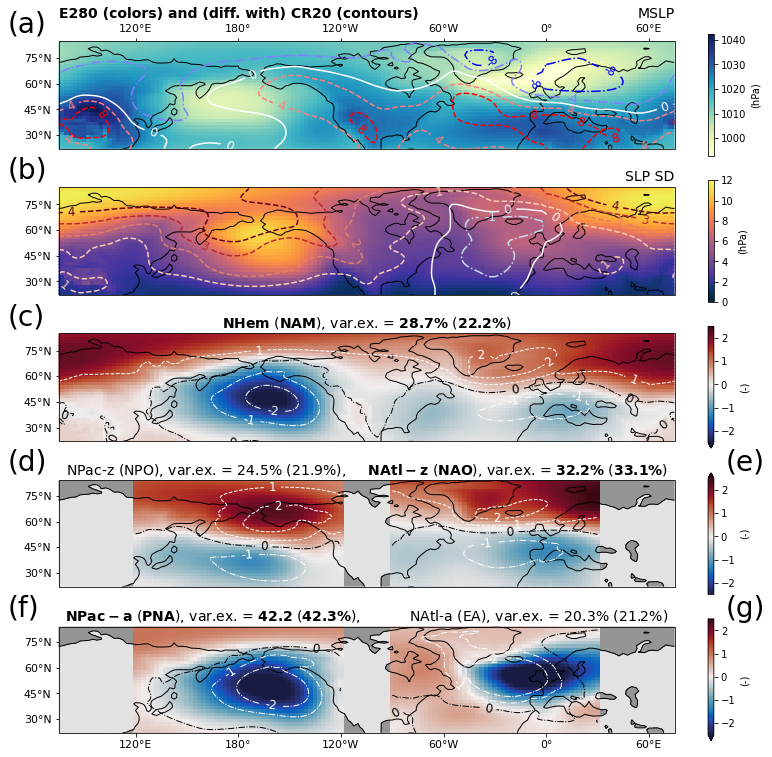

In [763]:
fig = plt.figure(figsize = (12,13), constrained_layout=False)

expN=1;
NH = nh1; SD = sdnh1; eofsh = eofsh1; eofsp = eofsp1; eofsa = eofsa1; expname = 'E280 (pre industrial)';

CR_mean = NH_mean_re.interp_like(nh1.mean("time"))
CR_std  = NH_sd_re.interp_like(nh1.std("time"))

meandiff = 0.01*xr.DataArray(gaussian_filter(nh1.mean("time") - CR_mean, sigma=1.5), coords=CR_mean.coords, dims=CR_mean.dims)
sddiff   = 0.01*xr.DataArray(gaussian_filter(nh1.std("time") - CR_std, sigma=1.5),   coords=CR_std.coords,  dims=CR_std.dims)

meandiff_, lon_ = cyclic(meandiff, coord=meandiff.lon); sddiff_, _ = cyclic(sddiff, coord=sddiff.lon);

hatching = 'x';
clon = -105;

ax = fig.add_subplot(5,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
c0=(0.01*nh1.mean("time")).plot(ax=ax, transform = ccrs.PlateCarree(), cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
# c1 = (0.01*CR_mean).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [1000, 1010, 1020, 1030], colors = ['k', 'k','w','w'], linestyles = ['--', '--', '--', '--'], linewidths = 1)
c1 = ax.contour(lon_, meandiff.lat, meandiff_, transform = ccrs.PlateCarree(), levels = [-8, -4, 0, 4, 8], cmap='bwr', linestyles = ['-.', '-.', '-', '--', '--'], linewidths = 1.5)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('MSLP', fontsize=14, loc='right'); ax.set_title('E280 (colors) and (diff. with) CR20 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(a)', color='k', fontsize = 28)

##

ax = fig.add_subplot(5,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(0.01*sdnh1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin= 0, vmax = 12, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = ax.contour(lon_, sddiff.lat, sddiff_, transform = ccrs.PlateCarree(), levels = [-4, -3, -2, -1, 0, 1, 2, 3, 4], cmap='RdBu_r', linestyles = ['-.', '-.', '-.', '-.', '-', '--', '--', '--', '--'], linewidths = 1.5)
# c1 = (0.01*CR_std).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2,4,6], colors = ['w', 'w', 'w'], linestyles = ['--', '--', '--', '--'], linewidths = 1)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title(''); ax.set_title('SLP SD', fontsize=14, loc='right'); 
lat_ticks(ax); ax.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())

ax.text(-210, 90, '(b)', color='k', fontsize = 28)

## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.5; vmin2 = vmin1; vmax1 = 2.5; vmax2 = vmax1;

ax2 = fig.add_subplot(5,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
eofsh.eofs.isel(mode=0).plot(ax=ax2, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax2.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsh_re.eofs.isel(mode=0), ax2)
ax2.set_title(fr'$\bf NHem$ ($\bf NAM$), var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\%$ ($\bf{varfs(eofsh_re.isel(mode=0))}\%$)', fontsize=14); #ax2.coastlines()

lat_ticks(ax2); ax2.set_extent([75, 285, 22, 85], crs=ccrs.PlateCarree())                                         

ax2.text(-210, 90, '(c)', color='k', fontsize = 28)

## 

ax4 = fig.add_subplot(5,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax4, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax4.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
eofsp.eofs.isel(mode=1).plot(ax=ax4, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
eofsa.eofs.isel(mode=0).plot(ax=ax4, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax4.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp_re.eofs.isel(mode=1), ax4)
contourlines(eofsa_re.eofs.isel(mode=0), ax4)
ax4.set_title(fr'NPac-z (NPO), var.ex. = {varfs(eofsp.isel(mode=1))}% ({varfs(eofsp_re.isel(mode=1))}%), {4*chr(0x20)}'
               fr'$\bf NAtl-z$ ($\bf NAO$), var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa_re.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax4); ax4.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())

ax4.text(-210, 90, '(d)', color='k', fontsize = 28)
ax4.text(210, 90, '(e)', color='k', fontsize = 28)

##

ax5 = fig.add_subplot(5,1,5, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax5, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax5.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
(1*eofsp.eofs.isel(mode=0)).plot(ax=ax5, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
eofsa.eofs.isel(mode=1).plot(ax=ax5, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax5.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp_re.eofs.isel(mode=0), ax5)
contourlines((eofsa_re.eofs.isel(mode=1)), ax5)
ax5.set_title(fr'$\bf NPac-a$ ($\bf PNA$), var.ex. = $\bf{varfs(eofsp.isel(mode=0))}%$ ($\bf{varfs(eofsp_re.isel(mode=0))}\%$), {10*chr(0x20)}'
               fr'NAtl-a (EA), var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa_re.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax5); lon_ticks(ax5, 'bottom'); ax5.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())

ax5.text(-210, 90, '(f)', color='k', fontsize = 28)
ax5.text(210, 90, '(g)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURE1_raw.png', dpi=300)

In [456]:
print('E280 minus CR20')
print('')
print('mean +- ')
print('')
print(f'MSLP   difference: {np.round(0.01*(pi_m-cr_m).mean().values,3)} hPa +- {np.round(0.01*(pi_m-cr_m).std().values,3)} hPa')
print(f'SLP SD difference:  {np.round(0.01*(pi_s-cr_s).mean().values,3)} hPa +- {np.round(0.01*(pi_s-cr_s).std().values,3)} hPa')


E280 minus CR20

mean +- 1SD

MSLP   difference: -0.105 hPa +- 5.544 hPa
SLP SD difference:  1.606 hPa +- 1.734 hPa


## Figure 2


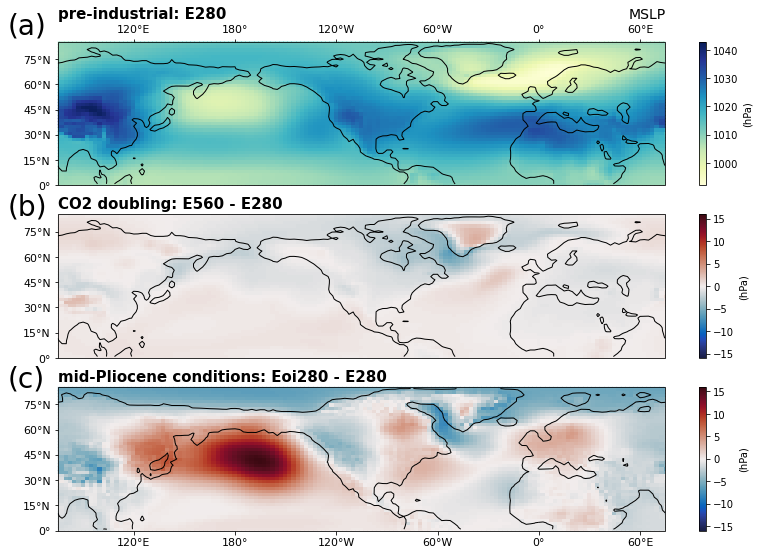

In [768]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

mslp1 = 0.01*ds1.SLP.sel(lat=slice(0,85)).mean("time")
mslp2 = 0.01*ds2.SLP.sel(lat=slice(0,85)).mean("time")
mslp3 = 0.01*ds3.SLP.sel(lat=slice(0,85)).mean("time")

clon = -105;
    
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
mslp1.plot(ax=ax, transform = ccrs.PlateCarree(),  vmin=992, vmax=1043, cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('pre-industrial: E280', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('MSLP', fontsize = 14, loc='right')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'top'); 
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp2 - mslp1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-16, vmax=16, cmap = 'cmo.balance', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=2).landfrac, linewidths = 1., levels=[lfnh.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('CO2 doubling: E560 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH2'); 
ax.text(-210, 85, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
(mslp3 - mslp1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-16, vmax=16, cmap = 'cmo.balance', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.set_title(''); ax.set_title('mid-Pliocene conditions: Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left');
lat_ticks(ax,'NH2'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 85, '(c)', color='k', fontsize = 28)


plt.savefig('200years/figures/FIGURE2_raw.png',dpi=300)

## Figure 3

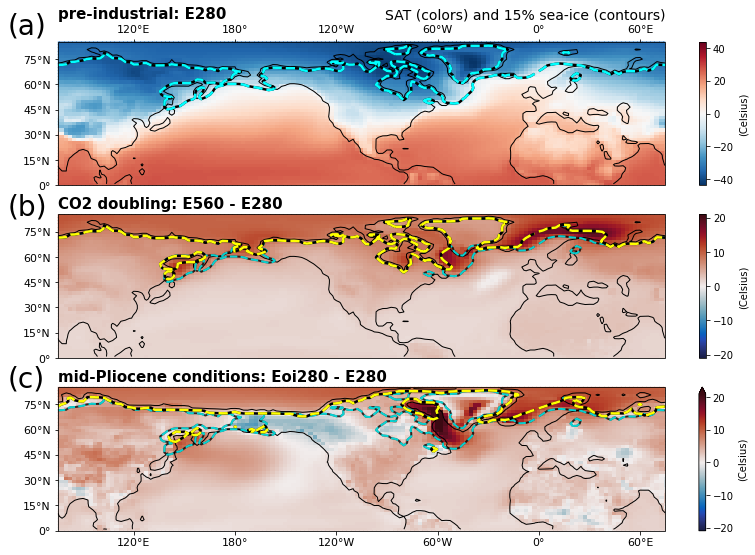

In [769]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

sat1 = ds1.SAT.sel(lat=slice(0,85)).mean("time"); icef1 = ds1.icefrac.sel(lat=slice(20,85)).mean("time");
sat2 = ds2.SAT.sel(lat=slice(0,85)).mean("time"); icef2 = ds2.icefrac.sel(lat=slice(20,85)).mean("time");
sat3 = ds3.SAT.sel(lat=slice(0,85)).mean("time"); icef3 = ds3.icefrac.sel(lat=slice(20,85)).mean("time");

clon = -105;
    
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
sat1.plot(ax=ax, transform = ccrs.PlateCarree(),  vmin=-44, vmax=44, cmap='RdBu_r', cbar_kwargs={'label':'(Celsius)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'k', linestyles = '-', linewidths=2.5)
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'aqua', linestyles = '--', linewidths=2.5)
ax.set_title(''); ax.set_title('pre-industrial: E280', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('SAT (colors) and 15% sea-ice (contours)', fontsize = 14, loc='right')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'top'); 
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(sat2 - sat1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-21, vmax=21, cmap='cmo.balance', cbar_kwargs={'label':'(Celsius)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=2).landfrac, linewidths = 1., levels=[lfnh.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'k', linestyles = '-', linewidths=2, alpha=0.8)
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'aqua', linestyles = '--', linewidths=2, alpha=0.8)
icef2.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'k', linestyles = '-', linewidths=2.5)
icef2.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'yellow', linestyles = '--', linewidths=2.5)
ax.set_title(''); ax.set_title('CO2 doubling: E560 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH2'); 
ax.text(-210, 85, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
(sat3 - sat1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-21, vmax=21, cmap='cmo.balance', cbar_kwargs={'label':'(Celsius)', 'fraction':0.03})
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'k', linestyles = '-', linewidths=2, alpha=0.8)
icef1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'aqua', linestyles = '--', linewidths=2, alpha=0.8)
icef3.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'k', linestyles = '-', linewidths=2.5)
icef3.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [.15], colors = 'yellow', linestyles = '--', linewidths=2.5)
ax.set_title(''); ax.set_title('mid-Pliocene conditions: Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 85, '(c)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURE3_raw.png',dpi=300)

## Figure 4

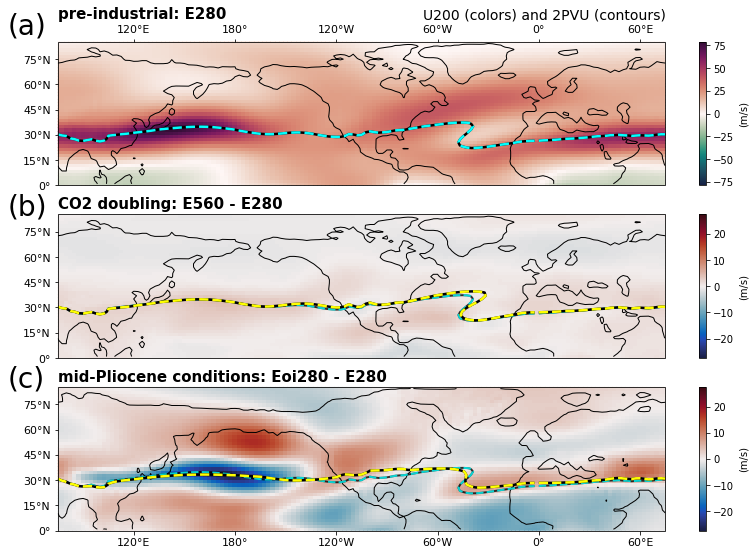

In [770]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

u2001 = dsp1.u.sel(plev=200).sel(lat=slice(0,85)).mean("time"); pv2001 = dsp1.pv.sel(plev=200).sel(lat=slice(0,85)).mean("time");
u2002 = dsp2.u.sel(plev=200).sel(lat=slice(0,85)).mean("time"); pv2002 = dsp2.pv.sel(plev=200).sel(lat=slice(0,85)).mean("time");
u2003 = dsp3.u.sel(plev=200).sel(lat=slice(0,85)).mean("time"); pv2003 = dsp3.pv.sel(plev=200).sel(lat=slice(0,85)).mean("time");

dyntroplev = 0.1

clon = -105;
    
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
u2001.plot(ax=ax, transform = ccrs.PlateCarree(),  vmin=-79, vmax=79, cmap='cmo.curl', cbar_kwargs={'label':'(m/s)', 'fraction':0.03} )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=1).clevel], colors = 'k', transform=ccrs.PlateCarree())
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'k', linestyles = '-', linewidths=2.5)
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2.5)
# dyntrop1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'k', linestyles = '-')
# dyntrop1.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'aqua', linestyles = '--')
ax.set_title(''); ax.set_title('pre-industrial: E280', fontsize = 15, fontweight = 'bold', loc='left');
ax.set_title('U200 (colors) and 2PVU (contours)', fontsize = 14, loc='right')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'top'); 
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
(u2002 - u2001).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-27.5, vmax=27.5, cmap='cmo.balance', cbar_kwargs={'label':'(m/s)', 'fraction':0.03} )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=2).landfrac, linewidths = 1., levels=[lfnh.sel(exp=2).clevel], colors = 'k', transform=ccrs.PlateCarree())
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'k', linestyles = '-', linewidths=2, alpha=0.8)
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2, alpha=0.8)
pv2002.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'k', linestyles = '-', linewidths=2.5)
pv2002.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
# dyntrop2.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'k', linestyles = '-')
# dyntrop2.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'yellow', linestyles = '--');
ax.set_title(''); ax.set_title('CO2 doubling: E560 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH2'); 
ax.text(-210, 85, '(b)', color='k', fontsize = 28)

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree(central_longitude=clon))
(u2003 - u2001).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=-27.5, vmax=27.5, cmap='cmo.balance', cbar_kwargs={'label':'(m/s)', 'fraction':0.03} )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'k', linestyles = '-', linewidths=2, alpha=0.8)
pv2001.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2, alpha=0.8)
pv2003.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'k', linestyles = '-', linewidths=2.5)
pv2003.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
# dyntrop3.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'k', linestyles = '-')
# dyntrop3.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels=[dyntroplev], colors = 'yellow', linestyles = '--')
ax.set_title(''); ax.set_title('mid-Pliocene conditions: Eoi280 - E280', fontsize = 15, fontweight = 'bold', loc='left')
lat_ticks(ax,'NH2'); lon_ticks(ax, 'bottom'); 
ax.text(-210, 85, '(c)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURE4_raw.png',dpi=300)


In [821]:
dsp1.u.sel(plev=200).sel(lat=slice(0,85)).std("time").mean()

<xarray.DataArray 'u' ()>
array(5.92577403)
Coordinates:
    plev     int64 200

## Figure 5

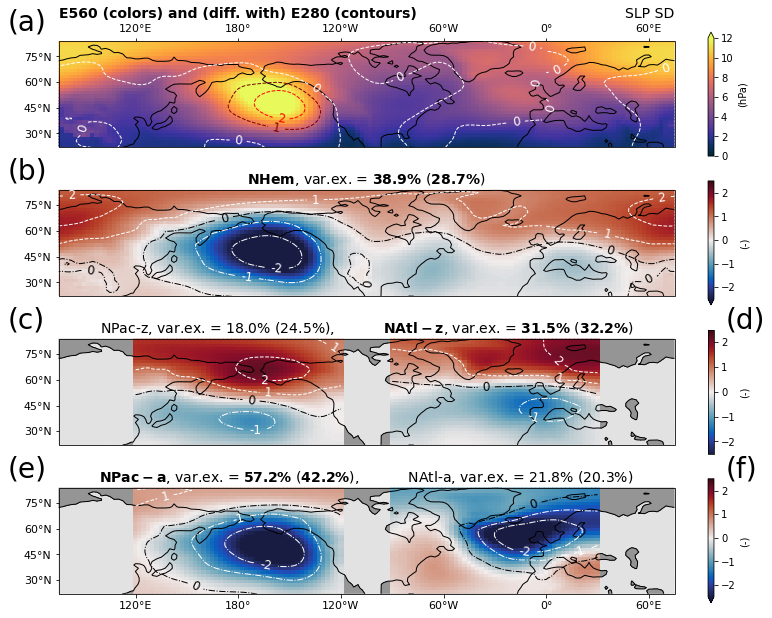

In [773]:
fig = plt.figure(figsize = (12,10.5), constrained_layout=False)

sd1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).std("time"); sd2 = 0.01*ds2.SLP.sel(lat=slice(20,85)).std("time");
sddiff = xr.DataArray(gaussian_filter(sd2-sd1, sigma=1.5), coords=sd2.coords, dims=sd2.dims)
expN = 2; eofsh = eofsh2; eofsp = eofsp2; eofsa = eofsa2; expname = 'E560 (CO2 doubling)';

clon = -105;
    
## 

ax = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
sd2.plot(ax=ax, transform = ccrs.PlateCarree(), vmin = 0, vmax = 12, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = sddiff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [0,1,2], colors = ['w', 'maroon', 'r'], linestyles = ['--', '--', '--'], linewidths = 1)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('SLP SD', fontsize=14, loc='right'); ax.set_title('E560 (colors) and (diff. with) E280 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(a)', color='k', fontsize = 28)
    
## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.5; vmin2 = vmin1; vmax1 = 2.5; vmax2 = vmax1;

ax = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
eofsh.eofs.isel(mode=0).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsh1.eofs.isel(mode=0), ax)
ax.set_title(fr'$\bf NHem$, var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\%$ ($\bf{varfs(eofsh1.isel(mode=0))}\%$)', fontsize=14);

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())                                              
ax.text(-210, 90, '(b)', color='k', fontsize = 28)
                                                                                                                                                                                     
##

ax = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
eofsp.eofs.isel(mode=1).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
eofsa.eofs.isel(mode=0).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=1), ax); contourlines(eofsa1.eofs.isel(mode=0), ax);
ax.set_title(fr'NPac-z, var.ex. = {varfs(eofsp.isel(mode=1))}% ({varfs(eofsp1.isel(mode=1))}%), {10*chr(0x20)}'
               fr'$\bf NAtl-z$, var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa1.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(c)', color='k', fontsize = 28)
ax.text(210, 90, '(d)', color='k', fontsize = 28)

##

ax = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
(1*eofsp.eofs.isel(mode=0)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
(1*eofsa.eofs.isel(mode=1)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=0), ax); contourlines(eofsa1.eofs.isel(mode=1), ax);
ax.set_title(fr'$\bf NPac-a$, var.ex. = $\bf{varfs(eofsp.isel(mode=0))}\%$ ($\bf{varfs(eofsp1.isel(mode=0))}\%$), {10*chr(0x20)}'
               fr'NAtl-a, var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa1.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax); lon_ticks(ax, 'bottom'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(e)', color='k', fontsize = 28)
ax.text(210, 90, '(f)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURE5_raw.png', dpi=300)


## Figure 6

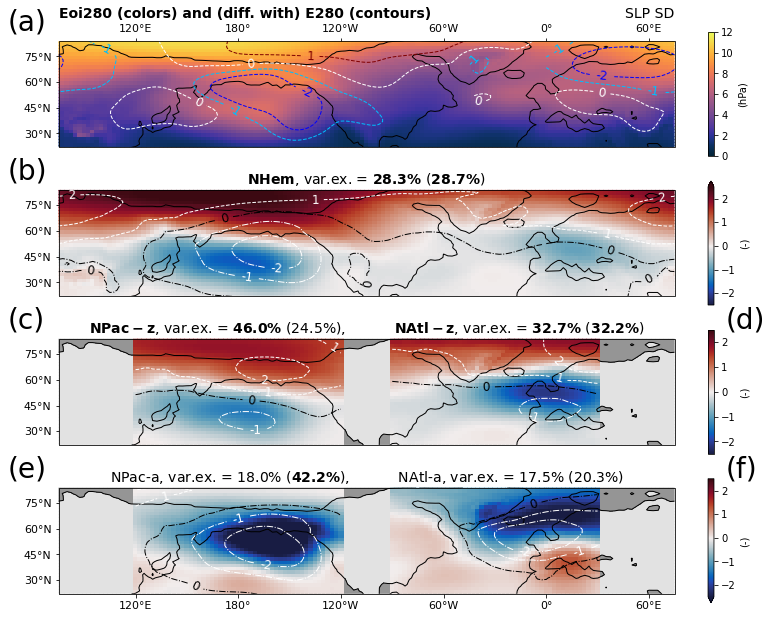

In [774]:
fig = plt.figure(figsize = (12,10.5), constrained_layout=False)

sd1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).std("time"); sd3 = 0.01*ds3.SLP.sel(lat=slice(20,85)).std("time");
sddiff = xr.DataArray(gaussian_filter(sd3-sd1, sigma=2), coords=sd2.coords, dims=sd2.dims)

expN = 3; NH = nh3; SD = sdnh3; eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3; expname = 'Eoi280 (mid Pliocene BCs)';

clon = -105;
    
## 

vmin1 = 0; vmin2 = vmin1; vmax1 = 12; vmax2 = vmax1;

ax = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
sd3.plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = sddiff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-2, -1,0,1], colors = ['blue','deepskyblue', 'w', 'maroon'], linestyles = ['--', '--', '--', '--'], linewidths = 1)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')
ax.set_title('SLP SD', fontsize=14, loc='right'); ax.set_title('Eoi280 (colors) and (diff. with) E280 (contours)', fontsize=14, loc='left', fontweight='bold')

lat_ticks(ax); lon_ticks(ax, 'top'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())    
ax.text(-210, 90, '(a)', color='k', fontsize = 28)

## Plot SLP EOFS: Northern Hemisphere, North Pacific and North Atlantic

vmin1 = -2.5; vmin2 = vmin1; vmax1 = 2.5; vmax2 = vmax1;

ax = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
eofsh.eofs.isel(mode=0).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsh1.eofs.isel(mode=0), ax)
ax.set_title(fr'$\bf NHem$, var.ex. = $\bf{varfs(eofsh.isel(mode=0))}\%$ ($\bf{varfs(eofsh1.isel(mode=0))}\%$)', fontsize=14);

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())                                   
ax.text(-210, 90, '(b)', color='k', fontsize = 28)
                                                                                                                              
##

ax = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
eofsp.eofs.isel(mode=0).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
eofsa.eofs.isel(mode=0).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=1), ax); contourlines(eofsa1.eofs.isel(mode=0), ax);
ax.set_title(fr'$\bf NPac-z$, var.ex. = $\bf{varfs(eofsp.isel(mode=0))}\%$ ({varfs(eofsp1.isel(mode=1))}%), {10*chr(0x20)}'
               fr'$\bf NAtl-z$, var.ex. = $\bf{varfs(eofsa.isel(mode=0))}\%$ ($\bf{varfs(eofsa1.isel(mode=0))}\%$)', fontsize=14); 

lat_ticks(ax); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(c)', color='k', fontsize = 28)
ax.text(210, 90, '(d)', color='k', fontsize = 28)

##

ax = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=clon))

(0.2+0*lfh.sel(exp=expN).landfrac).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='Greys',  add_colorbar=False)
ax.contourf(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac,  levels=[0, lfh.sel(exp=expN).clevel], cmap='Greys', transform=ccrs.PlateCarree())
(1*eofsp.eofs.isel(mode=1)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', add_colorbar=False)
(1*eofsa.eofs.isel(mode=1)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin = vmin1, vmax = vmax1, cmap = 'cmo.balance', cbar_kwargs={'label':'(-)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=expN).landfrac, linewidths = 1., levels=[lfh.sel(exp=expN).clevel], colors = 'k', transform=ccrs.PlateCarree())
contourlines(eofsp1.eofs.isel(mode=0), ax); contourlines(eofsa1.eofs.isel(mode=1), ax);
ax.set_title(fr'NPac-a, var.ex. = {varfs(eofsp.isel(mode=1))}% ($\bf{varfs(eofsp1.isel(mode=0))}\%$), {10*chr(0x20)}'
               fr'NAtl-a, var.ex. = {varfs(eofsa.isel(mode=1))}% ({varfs(eofsa1.isel(mode=1))}%)', fontsize=14); 

lat_ticks(ax); lon_ticks(ax, 'bottom'); ax.set_extent([75, 285, 22, 84], crs=ccrs.PlateCarree())
ax.text(-210, 90, '(e)', color='k', fontsize = 28)
ax.text(210, 90, '(f)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURE6_raw.png', dpi=300)

## Figure 7

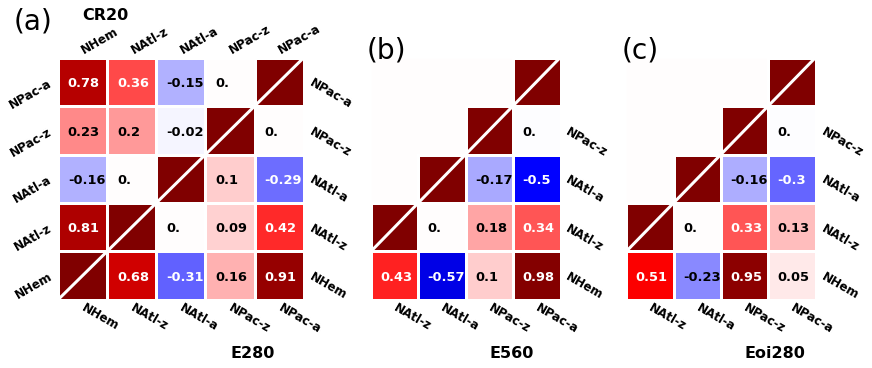

In [784]:
## Correlation between principal components

# make figure
fig = plt.figure(figsize = (12,5), constrained_layout="False")
widths = [1.3, 1, 1]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

# make subplot
ax = fig.add_subplot(spec[0])

##### E280 and CR20######

pclist = ['NHem', 'NAtl-z', 'NAtl-a', 'NPac-z', 'NPac-a']

eofsh = eofsh_re; eofsp = eofsp_re; eofsa = eofsa_re;
varflist_re = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs_re =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')

eofsh = eofsh1; eofsp = eofsp1; eofsa = eofsa1;
varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')

Npcs = len(pcs.mode)
coefs = np.zeros([Npcs, Npcs])

skiplist = np.arange(0,5)

# calculate coeffs
for i in range(Npcs):
    for j in range(0,skiplist[i]):
        coefs[i,j] = xr.corr(pcs_re[i,:], pcs_re[j,:], dim='time')
    for j in range(skiplist[i],Npcs):
        coefs[i,j] = xr.corr(pcs[i,:], pcs[j,:], dim='time')

# plot colors
axes = np.arange(0,Npcs+1,1)
ax.pcolormesh(axes, axes, coefs, vmin=-1, vmax = 1, cmap='seismic')
ax.plot(axes,axes, '-', linewidth=3, color='w')

# set text location
xtext = np.empty([Npcs,1]); ytext = np.empty([Npcs,1]);
for i in range(Npcs): xtext[i] = axes[i] + .2; ytext[i] = axes[i] + .4; 

# plot corr coeffs
for i in range(Npcs):
    for j in range(Npcs):
        clr = 'k'
        if coefs[i,j]>0.3 or coefs[i,j]<-0.25: clr = 'w';
        if abs(coefs[i,j])>0.01 and coefs[i,j]<0.99: ax.text(xtext[j], ytext[i], np.round(coefs[i,j],2), fontsize = 13, fontweight = 'bold', color = clr)
        if abs(coefs[i,j])<0.01: ax.text(xtext[j], ytext[i], '0.', fontsize = 13, fontweight = 'bold', color = clr)
#         if i==0: plt.text(xtext-1.5, ytext, f'({varflist[j]}%)', fontsize = 13, fontweight = 'bold')

ax.set_xticks(np.arange(.5,Npcs+0.5,1)); ax.set_xticklabels(pclist, fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist, fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=30, ha="left", va="center", rotation_mode="anchor")

plt.setp([tick.label1 for tick in ax.yaxis.get_major_ticks()], rotation=30, ha="right", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(.5, 5.8, 'CR20', fontsize = 16, fontweight = 'bold')
ax.text(3.5, -1.2, 'E280', fontsize = 16, fontweight = 'bold')

ax.text(-0.9, 5.6, '(a)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    ax.plot([0,Npcs], [i,i], 'w', linewidth=3)
    ax.plot([i,i], [0, Npcs], 'w', linewidth=3)

##################################################################################################################

eofsh = eofsh2; eofsp = eofsp2; eofsa = eofsa2;
# elif expN == 3: NH = nh3; SD = sdnh3; eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3; niva = niva3;  expname = 'Eoi280 (mid Pliocene BCs)';

varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,1), varperc(eofsp,0)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,1],   eofsp.pcs[:,0]], dim='mode')
coefs = np.zeros([Npcs, Npcs])

# calculate coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        coefs[i,j] = xr.corr(pcs[i,:], pcs[j,:], dim='time')

# make subplot
ax = fig.add_subplot(spec[1])

# plot colors
ax.pcolormesh(axes[1:], axes, coefs[:,1:], vmin=-1, vmax = 1, cmap='seismic')
ax.plot(axes[1:],axes[1:], '-', linewidth=3, color='w')

# plot corr coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        clr = 'k'
        if coefs[i,j]>0.3 or coefs[i,j]<-0.25: clr = 'w';
        if abs(coefs[i,j])>0.01 and coefs[i,j]<0.99: ax.text(xtext[j], ytext[i], np.round(coefs[i,j],2), fontsize = 13, fontweight = 'bold', color = clr)
        if abs(coefs[i,j])<0.01: ax.text(xtext[j], ytext[i], '0.', fontsize = 13, fontweight = 'bold', color = clr)

ax.set_xticks(np.arange(1.5,Npcs+0.5,1)); ax.set_xticklabels(pclist[1:], fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist[:-1]+[''], fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(3.5, -1.2, 'E560', fontsize = 16, fontweight = 'bold')

ax.text(0.9, 5.0, '(b)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    if i<2: start = 1;
    else: start = i-1;
    ax.plot([start, Npcs], [i,i], 'w' , linewidth=3)
    ax.plot([start, start], [0, start+1], 'w' , linewidth=3)

##################################################################################################################

eofsh = eofsh3; eofsp = eofsp3; eofsa = eofsa3;

varflist = np.array([varperc(eofsh,0), varperc(eofsa,0), varperc(eofsa,1), varperc(eofsp,0), varperc(eofsp,1)])
pcs =      xr.concat([eofsh.pcs[:,0],  eofsa.pcs[:,0],   eofsa.pcs[:,1],   eofsp.pcs[:,0],   eofsp.pcs[:,1]], dim='mode')
coefs = np.zeros([Npcs, Npcs])

# calculate coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        coefs[i,j] = xr.corr(pcs[i,:], pcs[j,:], dim='time')

# make subplot
ax = fig.add_subplot(spec[2])

# plot colors
ax.pcolormesh(axes[1:], axes, coefs[:,1:], vmin=-1, vmax = 1, cmap='seismic')
ax.plot(axes[1:],axes[1:], '-', linewidth=3, color='w')

#plot corr coeffs
for i in range(Npcs):
    for j in range(skiplist[i],Npcs):
        clr = 'k'
        if coefs[i,j]>0.3 or coefs[i,j]<-0.25: clr = 'w';
        if abs(coefs[i,j])>0.01 and coefs[i,j]<0.99: ax.text(xtext[j], ytext[i], np.round(coefs[i,j],2), fontsize = 13, fontweight = 'bold', color = clr)
        if abs(coefs[i,j])<0.01: ax.text(xtext[j], ytext[i], '0.', fontsize = 13, fontweight = 'bold', color = clr)

ax.set_xticks(np.arange(1.5,Npcs+0.5,1)); ax.set_xticklabels(pclist[1:], fontsize = 12, fontweight = 'bold');
ax.set_yticks(np.arange(.5,Npcs+0.5,1)); ax.set_yticklabels(pclist[:-1]+[''], fontsize = 12, fontweight = 'bold');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=False, top=False, left=False, right=False)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")
plt.setp([tick.label2 for tick in ax.yaxis.get_major_ticks()], rotation=-30, ha="left", va="center", rotation_mode="anchor")

ax.text(3.5, -1.2, 'Eoi280', fontsize = 16, fontweight = 'bold')

ax.text(0.9, 5.0, '(c)', fontsize = 28)

for spine in ax.spines.values(): spine.set_edgecolor('w')
    
for i in range(Npcs+1):
    if i<2: start = 1;
    else: start = i-1;
    ax.plot([start, Npcs], [i,i], 'w' , linewidth=3)
    ax.plot([start, start], [0, start+1], 'w' , linewidth=3)
#
plt.savefig('200years/figures/FIGURE7_raw.png', dpi=300)

## Figure 8

/var/folders/zp/m26x0gk57nj6hdttc43z96lr0000gn/T/ipykernel_81237/1808444062.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(times, u1.lat, u1.T, vmin=-74, vmax=74, cmap='cmo.curl')
/var/folders/zp/m26x0gk57nj6hdttc43z96lr0000gn/T/ipykernel_81237/1808444062.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(times, u3.lat, u3.T, vmin=-74, vmax=74, cmap='cmo.curl')


Text(3.8, 73, '(d)')

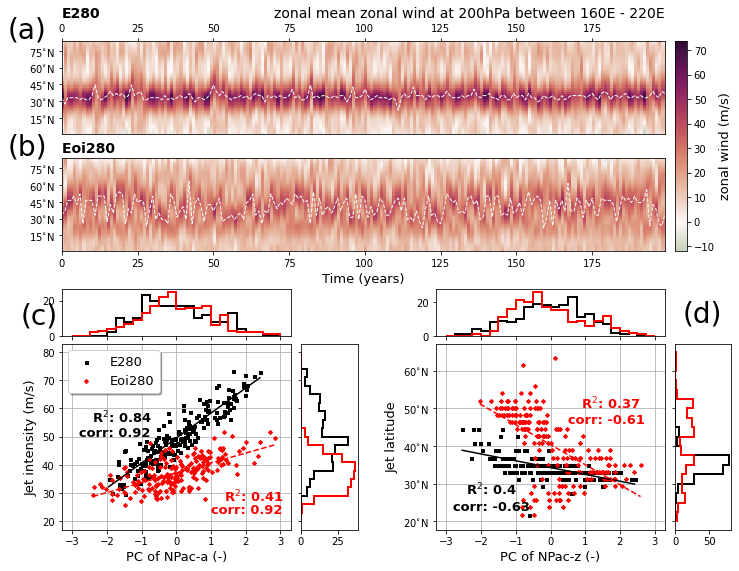

In [1067]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

mP_color = 'red'

widths = [4, 1, 1, 4, .2, .6]; heights = [2, 0.2, 2, 0.5, 1, 4];
spec = fig.add_gridspec(ncols=6, nrows=6, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

lats=np.array([15,30,45,60,75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

lats2=np.array([20, 30, 40, 50, 60]); 
latlabels2 = [f'{lats2[i]}'+degN for i in range(len(lats2))];

ax = fig.add_subplot(spec[0,0:-2])

pc=ax.pcolormesh(times, u1.lat, u1.T, vmin=-74, vmax=74, cmap='cmo.curl')
ax.plot(times, latu1, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
# ax.set_xlabel('Time (years)')
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
ax.xaxis.set_label_position("top")
ax.set_title('E280', fontsize=14, loc='left', fontweight='bold')
ax.set_title('zonal mean zonal wind at 200hPa between 160E - 220E', fontsize=14, loc='right'); 

ax.text(-18, 87, '(a)', fontsize=28)

ax = fig.add_subplot(spec[2,0:-2])

ax.pcolormesh(times, u3.lat, u3.T, vmin=-74, vmax=74, cmap='cmo.curl')
ax.plot(times, latu3, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
ax.set_xlabel('Time (years)',fontsize=13)
ax.set_title('Eoi280 ', fontsize=14, loc='left', fontweight='bold')

ax.text(-18, 87, '(b)', fontsize=28)

ax = fig.add_subplot(spec[0:3,4:5])

cmap1 = plt.get_cmap('cmo.curl')
vmin_old = -74; vmin =-12  #minimum value to show on colobar
vmax_old = 74;  vmax = 74 #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)
colors = cmap1(np.linspace((vmin-vmin_old)/(vmax_old-vmin_old), (vmax-vmin_old)/(vmax_old-vmin_old), cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm); cbar.set_label('zonal wind (m/s)', fontsize=13); 

#####################################################################################################################################################################

ax = fig.add_subplot(spec[5, 0]); ax_histx = fig.add_subplot(spec[4, 0], sharex=ax); ax_histy = fig.add_subplot(spec[5, 1], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npaca1, maxu1, color='k', marker = 's', s=9, label='E280')
ax.scatter(npaca3, maxu3, color=mP_color, marker = 'D', s=8, label='Eoi280')

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 83, 3)
scatter_hist(npaca1, maxu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npaca3, maxu3, ax_histx, ax_histy, binsx, binsy, mP_color)

# ax.set_xlim([-3,3]); ax.set_ylim([20,80]); 
ax.set_ylabel('Jet intensity (m/s)', fontsize=13); ax.set_xlabel('PC of NPac-a (-)', fontsize=13)
ax.legend(fontsize=13, shadow=True)

model = np.polyfit(npaca1, maxu1, 1); predict = np.poly1d(model); y1 = predict(npaca1)
rsq = r2_score(maxu1, y1)
x1 = np.array([npaca1.min(), npaca1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-')
ax.text(-2.8, 55, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 50, f'corr: {np.round(np.corrcoef(npaca1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

ax.text(-4.5, 90, '(c)', fontsize=28)

model = np.polyfit(npaca3, maxu3, 1); predict = np.poly1d(model); y3 = predict(npaca3)
rsq = r2_score(maxu3, y3)
x3 = np.array([npaca3.min(), npaca3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color)
ax.text(1, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(1, 23, f'corr: {np.round(np.corrcoef(npaca1, maxu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

####

ax = fig.add_subplot(spec[5, 3]); ax_histx = fig.add_subplot(spec[4, 3], sharex=ax); ax_histy = fig.add_subplot(spec[5, 4:], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(npacz1, latu1, color='k', marker = 's', s=9)
ax.scatter(npacz3, latu3, color=mP_color, marker = 'D', s=8)

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(20, 67.5, 2.5)
scatter_hist(npacz1, latu1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(npacz3, latu3, ax_histx, ax_histy, binsx, binsy, mP_color)

# ax.set_xlim([-3,3]); ax.set_ylim([20, 65]); 
ax.set_yticks(lats2); ax.set_yticklabels(latlabels2);
ax.set_ylabel('Jet latitude', fontsize=13); ax.set_xlabel('PC of NPac-z (-)', fontsize=13)

model = np.polyfit(npacz1, latu1, 1); predict = np.poly1d(model); y1 = predict(npacz1)
rsq = r2_score(latu1, y1)
x1 = np.array([npacz1.min(), npacz1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-'); #ax.text(-2.5, 27, f'R$^2$ = {np.round(rsq,2)}', fontsize=12)
ax.text(-2.8, 27, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 23, f'corr: {np.round(np.corrcoef(npacz1, latu1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

model = np.polyfit(npacz3, latu3, 1); predict = np.poly1d(model); y3 = predict(npacz3)
rsq = r2_score(latu3, y3)
x3 = np.array([npacz3.min(), npacz3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color); 
ax.text(0.5, 50, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(0.5, 46, f'corr: {np.round(np.corrcoef(npacz3, latu3)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

ax.text(3.8, 73, '(d)', fontsize=28)

# plt.savefig('200years/figures/FIGURE8_raw.png', dpi=300)


# Figure 9

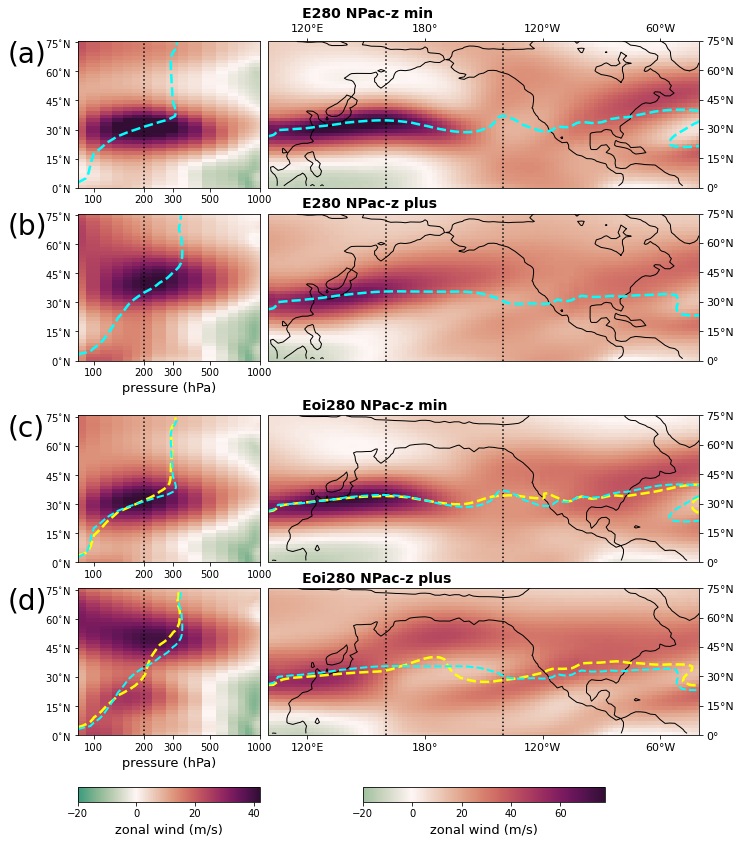

In [806]:
fig = plt.figure(figsize = (12,14), constrained_layout=False)

vmin=-78; vmax=78; vmin2=-42; vmax2=42; cmap = 'cmo.curl';

widths = [0.3, 0.3, 0.4, 0.3]; heights = [1, 1, 0.02, 1, 1, 0.0, 0.1];
spec = fig.add_gridspec(ncols=4, nrows=7, width_ratios=widths, height_ratios=heights, wspace=-0.2, hspace=0.3)

clon = -105;

lats=np.array([0, 15, 30, 45, 60, 75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

levs=np.array([1000, 500, 300, 200, 100]);
levlabels = [f'{levs[i]}' for i in range(len(levs))];

l1 = 100; l2 = 320;
lonslice = np.array([160, 220]);

ax = fig.add_subplot(spec[0,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.curl', add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('       E280 NPac-z min', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); lon_ticks(ax, 'top', lons=[120,180, -120, -60])

ax=fig.add_subplot(spec[0,0])

u1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot(ax=ax, vmin=vmin2, vmax=vmax2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'cyan', linestyles = '--', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(a)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[1,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.curl', add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2.5)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('       E280 NPac-z plus', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax=fig.add_subplot(spec[1,0])

u1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot(ax=ax, vmin=vmin2, vmax=vmax2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'cyan', linestyles = '--', linewidths=2.5)
ax.set_xlim([80, 1000]); ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('pressure (hPa)', fontsize=13);
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(b)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[3,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u3_min.sel(plev=200).sel(lon=slice(l1,l2)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.curl', add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.sel(lat=slice(0,75)).lat, lfnh.sel(lon=slice(l1,l2), lat=slice(0,75)).sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv3_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
pv1_min.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('       Eoi280 NPac-z min', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax=fig.add_subplot(spec[3,0])

u3_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot(ax=ax, vmin=vmin2, vmax=vmax2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv3_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
pv1_min.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'cyan', linestyles = '--', linewidths=2)
ax.set_xlim([80, 1000]); ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('');
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(c)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[4,1:], projection=ccrs.PlateCarree(central_longitude=clon))

u3_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.curl', add_colorbar=False   )
ax.contour(lfnh.sel(lon=slice(l1,l2)).lon, lfnh.lat, lfnh.sel(lon=slice(l1,l2)).sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,75], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
pv3_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
pv1_plus.sel(plev=200).sel(lon=slice(l1,l2)).plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [2], colors = 'cyan', linestyles = '--', linewidths=2)
ax.set_extent([l1, l2, 0, 75], crs=ccrs.PlateCarree())
ax.set_title('       Eoi280 NPac-z plus', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom', lons=[120,180, -120, -60])

ax=fig.add_subplot(spec[4,0])

u3_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot(ax=ax, vmin=vmin2, vmax=vmax2, cmap=cmap, add_colorbar=False)
ax.plot([200,200], [0,75],'k:',zorder=1)
pv3_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'yellow', linestyles = '--', linewidths=2.5)
pv1_plus.sel(lon=slice(lonslice[0], lonslice[1])).mean("lon").T.plot.contour(ax=ax, levels = [2], colors = 'cyan', linestyles = '--', linewidths=2)
ax.set_xlim([80, 1000]); ax.set_xscale("log"); ax.minorticks_off();
ax.set_yticks(lats); ax.set_yticklabels(latlabels); ax.set_ylabel('');
ax.set_xticks(levs); ax.set_xticklabels(levlabels); ax.set_xlabel('pressure (hPa)', fontsize=13);
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)

ax.text(30, 65, '(d)', fontsize = 28)

ax = fig.add_subplot(spec[6,0])

cmap1 = plt.get_cmap('cmo.curl')
vmin_old = vmin2;  vmin_ = -20  #minimum value to show on colobar
vmax_old = vmax2;  vmax_ = vmax2 #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin_, vmax =vmax_)
colors = cmap1(np.linspace((vmin_-vmin_old)/(vmax_old-vmin_old), (vmax_-vmin_old)/(vmax_old-vmin_old), cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, orientation='horizontal'); cbar.set_label('zonal wind (m/s)', fontsize=13); 

ax = fig.add_subplot(spec[6,2])

cmap1 = plt.get_cmap('cmo.curl')
vmin_old = vmin; vmin_ =-20  #minimum value to show on colobar
vmax_old = vmax;  vmax_ = vmax #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin_, vmax =vmax_)
colors = cmap1(np.linspace((vmin_-vmin_old)/(vmax_old-vmin_old), (vmax_-vmin_old)/(vmax_old-vmin_old), cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, orientation='horizontal'); cbar.set_label('zonal wind (m/s)', fontsize=13); 

# plt.savefig('200years/figures/FIGURE9_raw.pdf')
# plt.savefig('200years/figures/FIGURE9_raw.png', dpi=300)



# SUPPLEMENTARY MATERIAL

In [149]:

from matplotlib.patches import Rectangle
import scipy.io

mat = scipy.io.loadmat('spinup/Rad_Tseries_yearly.mat')
e280_T=mat["Tm"];       e280_T=e280_T[0:340];
e280_time=mat["years"]; e280_time=e280_time[0:340];

d1 = xr.open_dataset('spinup/E280p_Atmosphere_years_2500-4000.nc').temp
d2 = xr.open_dataset('spinup/E280p_Atmosphere_years_4001-4250.nc').temp
d3 = xr.open_dataset('spinup/E280p_Atmosphere_years_4251-4500.nc').temp
d4 = xr.open_dataset('spinup/E280p_Atmosphere_years_4501-4715.nc').temp
d5 = xr.open_dataset('spinup/E280p_Atmosphere_years_4716-4800.nc').temp
d6 = xr.open_dataset('spinup/E280p_Atmosphere_years_4801-5000.nc').temp
d7 = xr.open_dataset('spinup/E280p_Atmosphere_years_5001-5500.nc').temp
d8 = xr.open_dataset('spinup/E280p_Atmosphere_years_5501-6000.nc').temp
d9 = xr.open_dataset('spinup/E280p_Atmosphere_years_6001-6500.nc').temp
e280p = xr.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9], dim="time")

d1 = xr.open_dataset('spinup/E560_Atmosphere_years_3300-3535.nc').temp
d2 = xr.open_dataset('spinup/E560_Atmosphere_years_3536-4060.nc').temp
e560 = xr.concat([d1,d2], dim="time")

d1 = xr.open_dataset('spinup/E560p_Atmosphere_years_5001-5100.nc').temp
d2 = xr.open_dataset('spinup/E560p_Atmosphere_years_5101-5500.nc').temp
d3 = xr.open_dataset('spinup/E560p_Atmosphere_years_5501-6000.nc').temp
d4 = xr.open_dataset('spinup/E560p_Atmosphere_years_6001-6500.nc').temp
e560p = xr.concat([d1,d2,d3,d4], dim="time")

d1 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1-500.nc').temp
d2 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_501-1000.nc').temp
d3 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1001-1500.nc').temp
d4 = xr.open_dataset('spinup/Eoi400_Atmosphere_years_1501-2000.nc').temp
eoi400 = xr.concat([d1,d2,d3,d4], dim="time")[2:]

d1 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2001-2285.nc').temp
d2 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2251-2500.nc').temp
d3 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2501-2750.nc').temp
d4 = xr.open_dataset('spinup/Eoi280_Atmosphere_years_2751-3000.nc').temp
eoi280 = xr.concat([d1,d2,d3,d4], dim="time")

## FIGURE S1

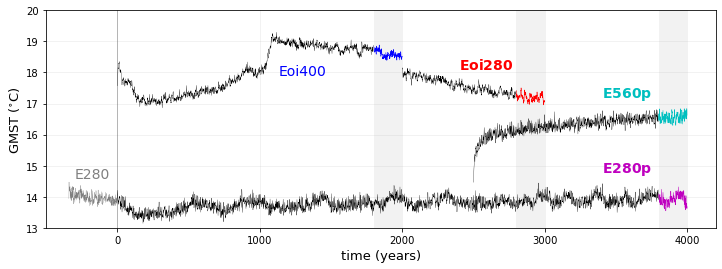

In [986]:
lw1 = 0.3; lw = 0.5;

fig,ax=plt.subplots(figsize=(12,4))

ax.plot(np.arange(-340,0), e280_T,label='E280', color='gray', linewidth=lw1)
ax.plot(np.arange(0,3801), e280p[0:-200], color='k', linewidth=lw1)
ax.plot(np.arange(3801,4001), e280p[-200:], color='m', linewidth=lw)
ax.plot(np.arange(2501,3801), e560p[0:-200], color='k', linewidth=lw1)
ax.plot(np.arange(3801,4001), e560p[-200:], color='c', linewidth=lw)

eoi400[0:-200].plot(color='k', linewidth=lw1)
eoi400[-200:].plot(color='b', linewidth=lw)
eoi280[0:-200].plot(color='k', linewidth=lw1)
eoi280[-200:].plot(color='r', linewidth=lw)

ax.set_ylim([13,20])
ax.set_xlim([-500,4200])
ax.grid("on", alpha=0.2)
ax.plot([0,0],[13,20],'k-', alpha=0.5, linewidth=0.5)

ax.add_patch(Rectangle((1800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))
ax.add_patch(Rectangle((2800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))
ax.add_patch(Rectangle((3800,13),200,7,linewidth=1,edgecolor='none',facecolor='gray',alpha=0.1,zorder=-1))

ax.text(-300, 14.6, 'E280', fontsize=14, color='gray')
ax.text(1130, 17.9, 'Eoi400', fontsize=14, color='b')
ax.text(2400, 18.1, r'$\bfEoi280$', fontsize=14, color='r')
ax.text(3400, 14.8, r'$\bfE280p$', fontsize=14, color='m')
ax.text(3400, 17.2, r'$\bfE560p$', fontsize=14, color='c')

# ax.legend(fontsize=13, bbox_to_anchor=(0.7, 0.95), shadow=True)

ax.set_ylabel(r'GMST ($^{\circ}$C)', fontsize=13); ax.set_xlabel('time (years)', fontsize=13)

# plt.savefig('spinup/spin_up1.pdf',dpi=500)
plt.savefig('200years/figures/FIGURES1_raw.png',dpi=300)

## FIGURE S2

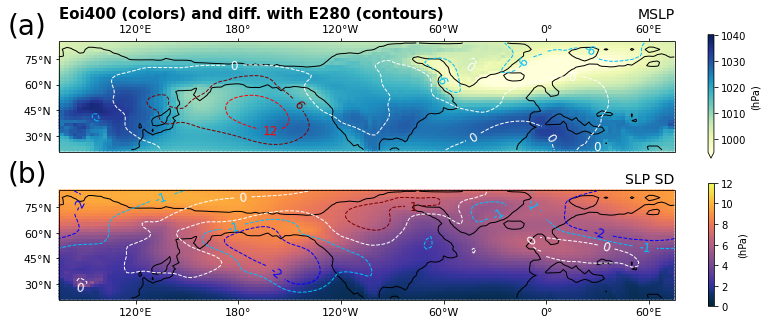

In [1078]:
fig = plt.figure(figsize = (12,5), constrained_layout=False)

mslp1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).mean("time")
mslp4 = 0.01*ds4.SLP.sel(lat=slice(20,85)).mean("time")

filtered = gaussian_filter(mslp4 - mslp1, sigma=1)
mslp_diff = xr.DataArray(filtered, coords=mslp1.coords, dims=mslp1.dims);

sd1 = 0.01*ds1.SLP.sel(lat=slice(20,85)).std("time")
sd4 = 0.01*ds4.SLP.sel(lat=slice(20,85)).std("time")

filtered = gaussian_filter(sd4 - sd1, sigma=1)
sd_diff = xr.DataArray(filtered, coords=mslp1.coords, dims=mslp1.dims);

clon = -105;
    
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree(central_longitude=clon))
mslp4.plot(ax=ax, transform = ccrs.PlateCarree(),  vmin=995, vmax=1040, cmap = 'YlGnBu', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=3).landfrac, linewidths = 1., levels=[lfh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = mslp_diff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-6, 0, 6, 12], colors = ['deepskyblue', 'w', 'maroon', 'r'], linestyles = ['--', '--', '--', '--'], linewidths = 1)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); ax.set_title('Eoi400 (colors) and diff. with E280 (contours)', fontsize = 15, fontweight = 'bold', loc='left'); 
ax.set_title('MSLP', fontsize = 14, loc='right')
lat_ticks(ax,'NH'); lon_ticks(ax, 'top'); 

ax.text(-210, 90, '(a)', color='k', fontsize = 28)


ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree(central_longitude=clon))
sd4.plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=12, cmap  = 'cmo.thermal', cbar_kwargs={'label':'(hPa)', 'fraction':0.03})
ax.contour(lfh.lon, lfh.lat, lfh.sel(exp=3).landfrac, linewidths = 1., levels=[lfh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
c1 = sd_diff.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-2, -1,0,1], colors = ['blue','deepskyblue', 'w', 'maroon'], linestyles = ['--', '--', '--', '--'], linewidths = 1)
c2 = ax.clabel(c1, c1.levels, fontsize=12, inline=True, fmt = '%1.0f')

ax.set_title(''); 
ax.set_title('SLP SD', fontsize = 14, loc='right')
lat_ticks(ax,'NH'); lon_ticks(ax,'bottom');

ax.text(-210, 90, '(b)', color='k', fontsize = 28)

plt.savefig('200years/figures/FIGURES2_raw.png',dpi=300)

## FIGURE S2b (Spectra - do not include)

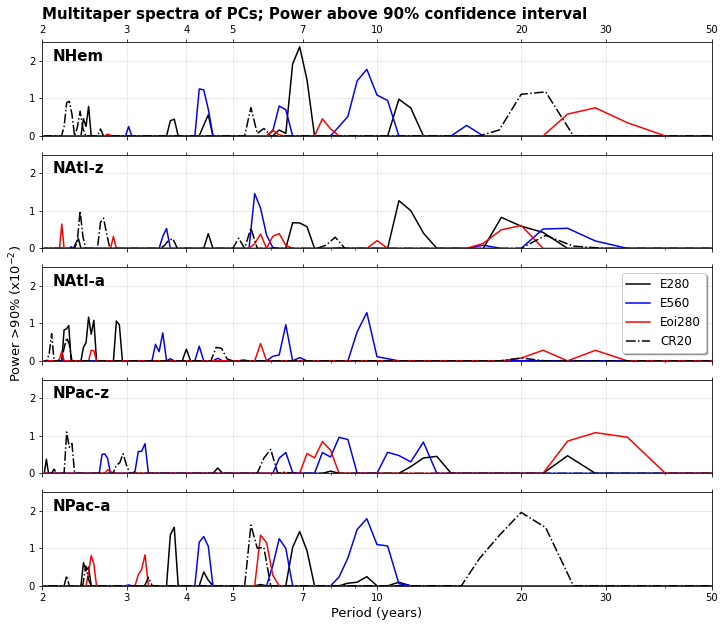

In [983]:
fig = plt.figure(figsize=(12,10))

Nsur = 1000;

# NHem / NAtl-z / NAtl-a / NPac-z / NPac-z

tslist1 = [eofsh1.isel(mode=0).pcs, eofsa1.isel(mode=0).pcs, eofsa1.isel(mode=1).pcs, eofsp1.isel(mode=1).pcs, eofsp1.isel(mode=0).pcs]
tslist2 = [eofsh2.isel(mode=0).pcs, eofsa2.isel(mode=0).pcs, eofsa2.isel(mode=1).pcs, eofsp2.isel(mode=1).pcs, eofsp2.isel(mode=0).pcs]
tslist3 = [eofsh3.isel(mode=0).pcs, eofsa3.isel(mode=0).pcs, eofsa3.isel(mode=1).pcs, eofsp3.isel(mode=0).pcs, eofsp3.isel(mode=1).pcs]
tslist_re = [eofsh_re.isel(mode=0).pcs, eofsa_re.isel(mode=0).pcs, eofsa_re.isel(mode=1).pcs, eofsp_re.isel(mode=1).pcs, eofsp_re.isel(mode=0).pcs]

titlelist = ['NHem', 'NAtl-z', 'NAtl-a', 'NPac-z', 'NPac-a']

for i in range(len(titlelist)):

    ax = fig.add_subplot(5,1,i+1)

    time_series = tslist1[i]; freq, spec1 = MT_spectrum(time_series, normalise = True, scale = True, trend = None, nbw = 2, ntapers = 3)
    c90,c95,c99 = Confidence_intervals(time_series, normalise=True, scale = True, trend = None, mode = 'MT', N_autocorr = np.ceil(0.75*len(time_series)), N_surrogates = Nsur, nbw = 2, ntapers = 3)

    time_series = tslist2[i]; _, spec2 = MT_spectrum(time_series, normalise = True, scale = True, trend = None, nbw = 2, ntapers = 3)
    time_series = tslist3[i]; _, spec3 = MT_spectrum(time_series, normalise = True, scale = True, trend = None, nbw = 2, ntapers = 3)
    
    p90_1 = (spec1-c90)*(spec1>c90);
    p90_2 = (spec2-c90)*(spec2>c90);
    p90_3 = (spec3-c90)*(spec3>c90);    
    
    freq_re, spec_re = MT_spectrum(tslist_re[i], normalise = True, scale = True, trend = None, nbw = 2, ntapers = 3)
    c90_re,_,_ = Confidence_intervals(tslist_re[i], normalise=True, scale = True, trend = None, mode = 'MT', N_autocorr = np.ceil(0.75*len(tslist_re[i])), N_surrogates = Nsur, nbw = 2, ntapers = 3)
    p90_re = (spec_re-c90_re)*(spec_re>c90_re);    
    
    ax.plot(1/freq, 100*p90_1, 'k-', label='E280')
    ax.plot(1/freq, 100*p90_2, 'b-', label='E560')
    ax.plot(1/freq, 100*p90_3, 'r-', label='Eoi280')
    ax.plot(1/freq_re, 100*p90_re, 'k-.', label = 'CR20')
    
    ax.set_ylim([0, 2.5]);
    if i==2: ax.tick_params(axis="y", left=True, right=False, labelleft=True, labelright=False); ax.set_ylabel(r'Power >90% (x$10^{-2}$)', fontsize=13);
    
    ax.set_xlim([2,50]); ax.set_xscale("log"); 
    if i==0: ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True); 
    elif i==1 or i==2 or i==3: ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=False);
    elif i==4: ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False); ax.set_xlabel('Period (years)', fontsize=13); 
    xticks = np.array([2, 3, 4, 5, 7, 10, 20, 30, 50]); 
    ax.xaxis.set_ticks(xticks); ax.xaxis.set_ticklabels(xticks);
    
    ax.grid("on", alpha=0.3)

    if i==2: ax.legend(fontsize=12, shadow=True);    
    ax.text(2.1, 2.0, f'{titlelist[i]}', fontsize = 15, fontweight = 'bold')
    
    if i==0: plt.title('Multitaper spectra of PCs; Power above 90% confidence interval', fontsize = 15, fontweight = 'bold', loc='left')

# plt.savefig('200years/figures/SLP_PCs_spectra>90.png', dpi=200)

## FIGURE S3

/var/folders/zp/m26x0gk57nj6hdttc43z96lr0000gn/T/ipykernel_81237/2712822880.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(times, unh1.lat, unh1.T, vmin=-53, vmax=53, cmap='cmo.curl')
/var/folders/zp/m26x0gk57nj6hdttc43z96lr0000gn/T/ipykernel_81237/2712822880.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(times, unh3.lat, unh3.T, vmin=-53, vmax=53, cmap='cmo.curl')


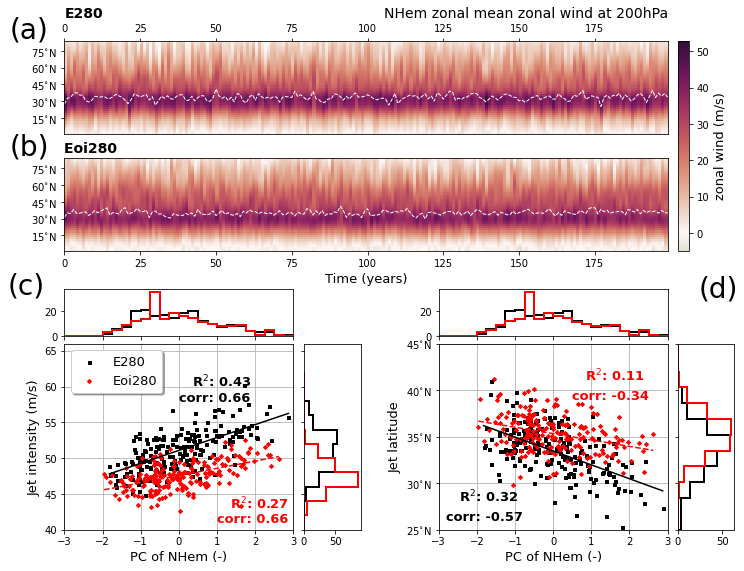

In [1077]:
fig = plt.figure(figsize = (12,9), constrained_layout=False)

mP_color = 'red'

widths = [4, 1, 1, 4, .2, .6]; heights = [2, 0.2, 2, 0.5, 1, 4];
spec = fig.add_gridspec(ncols=6, nrows=6, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

lats=np.array([15,30,45,60,75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

lats2=np.array([25, 30, 35, 40, 45]); 
latlabels2 = [f'{lats2[i]}'+degN for i in range(len(lats2))];

ax = fig.add_subplot(spec[0,0:-2])

pc=ax.pcolormesh(times, unh1.lat, unh1.T, vmin=-53, vmax=53, cmap='cmo.curl')
ax.plot(times, latunh1, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
# ax.set_xlabel('Time (years)')
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
ax.xaxis.set_label_position("top")
ax.set_title('E280', fontsize=14, loc='left', fontweight='bold')
ax.set_title('NHem zonal mean zonal wind at 200hPa', fontsize=14, loc='right'); 

ax.text(-18, 87, '(a)', fontsize=28)

ax = fig.add_subplot(spec[2,0:-2])

ax.pcolormesh(times, unh3.lat, unh3.T, vmin=-53, vmax=53, cmap='cmo.curl')
ax.plot(times, latunh3, 'k', linestyle='--', linewidth=1, color='w')
ax.set_yticks(lats); ax.set_yticklabels(latlabels); #ax.set_ylabel('Latitude');
ax.set_xlabel('Time (years)',fontsize=13)
ax.set_title('Eoi280 ', fontsize=14, loc='left', fontweight='bold')

ax.text(-18, 87, '(b)', fontsize=28)

ax = fig.add_subplot(spec[0:3,4:5])

cmap1 = plt.get_cmap('cmo.curl')
vmin_old = -53; vmin =-5  #minimum value to show on colobar
vmax_old = 53;  vmax = 53 #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)
colors = cmap1(np.linspace((vmin-vmin_old)/(vmax_old-vmin_old), (vmax-vmin_old)/(vmax_old-vmin_old), cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.curl', colors)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm); cbar.set_label('zonal wind (m/s)', fontsize=13); 

#####################################################################################################################################################################

ax = fig.add_subplot(spec[5, 0]); ax_histx = fig.add_subplot(spec[4, 0], sharex=ax); ax_histy = fig.add_subplot(spec[5, 1], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(nhem1, maxunh1, color='k', marker = 's', s=9, label='E280')
ax.scatter(nhem3, maxunh3, color=mP_color, marker = 'D', s=8, label='Eoi280')

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(30, 64, 2)
scatter_hist(nhem1, maxunh1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(nhem3, maxunh3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); ax.set_ylim([40,66]); 
ax.set_ylabel('Jet intensity (m/s)', fontsize=13); ax.set_xlabel('PC of NHem (-)', fontsize=13)
ax.legend(fontsize=13, shadow=True)

model = np.polyfit(nhem1, maxunh1, 1); predict = np.poly1d(model); y1 = predict(nhem1)
rsq = r2_score(maxunh1, y1)
x1 = np.array([nhem1.min(), nhem1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-')
ax.text(0, 60, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(0, 58, f'corr: {np.round(np.corrcoef(nhem1, maxunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

ax.text(-4.5, 73, '(c)', fontsize=28)

model = np.polyfit(nhem3, maxunh3, 1); predict = np.poly1d(model); y3 = predict(nhem3)
rsq = r2_score(maxunh3, y3)
x3 = np.array([nhem3.min(), nhem3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color)
ax.text(1, 43, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(1, 41, f'corr: {np.round(np.corrcoef(nhem1, maxunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

####

ax = fig.add_subplot(spec[5, 3]); ax_histx = fig.add_subplot(spec[4, 3], sharex=ax); ax_histy = fig.add_subplot(spec[5, 4:], sharey=ax);
ax.grid("on"); ax.set_axisbelow(True)
ax.scatter(nhem1, latunh1, color='k', marker = 's', s=9)
ax.scatter(nhem3, latunh3, color=mP_color, marker = 'D', s=8)

binsx = np.arange(-3, 3.25, 0.25); binsy = np.arange(25., 45.5, 1.7)
scatter_hist(nhem1, latunh1, ax_histx, ax_histy, binsx, binsy, 'k')
scatter_hist(nhem3, latunh3, ax_histx, ax_histy, binsx, binsy, mP_color)

ax.set_xlim([-3,3]); 
ax.set_ylim([25, 45]); 
ax.set_yticks(lats2); ax.set_yticklabels(latlabels2);
ax.set_ylabel('Jet latitude', fontsize=13); ax.set_xlabel('PC of NHem (-)', fontsize=13)

model = np.polyfit(nhem1, latunh1, 1); predict = np.poly1d(model); y1 = predict(nhem1)
rsq = r2_score(latunh1, y1)
x1 = np.array([nhem1.min(), nhem1.max()]); y1 = predict(x1)
ax.plot(x1,y1, 'k-'); #ax.text(-2.5, 27, f'R$^2$ = {np.round(rsq,2)}', fontsize=12)
ax.text(-2.8, 28, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color='k')
ax.text(-2.8, 26, f'corr: {np.round(np.corrcoef(nhem1, latunh1)[0,1],2)}', fontsize=13, fontweight = 'bold', color='k')

model = np.polyfit(nhem3, latunh3, 1); predict = np.poly1d(model); y3 = predict(nhem3)
rsq = r2_score(latunh3, y3)
x3 = np.array([nhem3.min(), nhem3.max()]); y3 = predict(x3)
ax.plot(x3,y3, '--', color=mP_color); 
ax.text(0.5, 41, f'   R$^2$: {np.round(rsq,2)}', fontsize=13, fontweight = 'bold', color=mP_color)
ax.text(0.5, 39, f'corr: {np.round(np.corrcoef(nhem3, latunh3)[0,1],2)}', fontsize=13, fontweight = 'bold', color=mP_color)

ax.text(3.8, 50, '(d)', fontsize=28)

plt.savefig('200years/figures/FIGURES3_raw.png', dpi=300)

## FIGURE S4

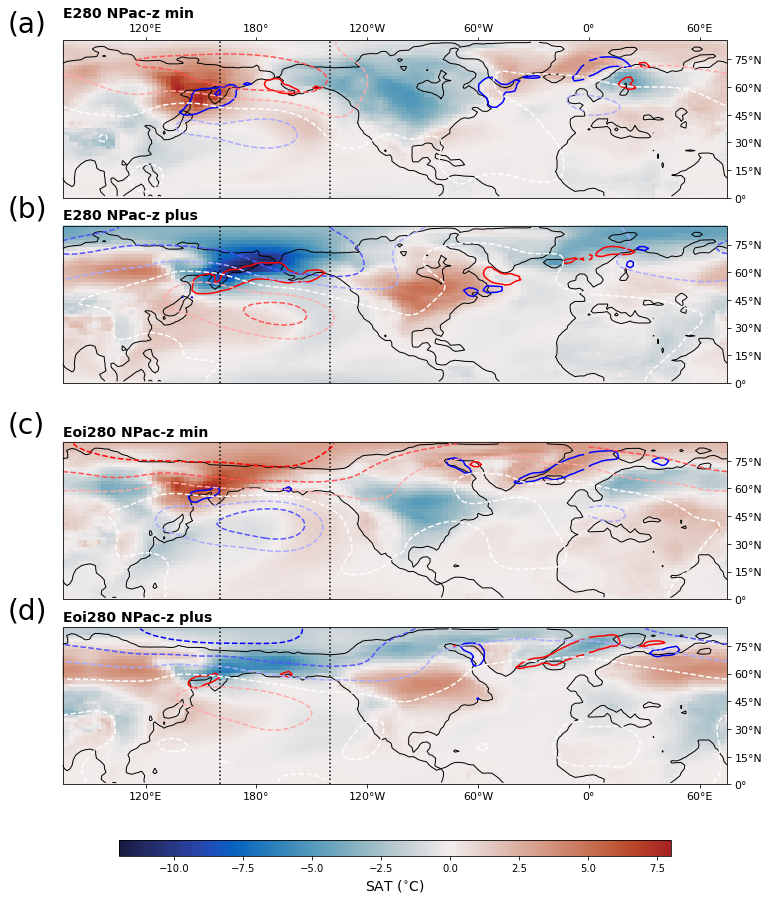

In [996]:
fig = plt.figure(figsize = (12,15), constrained_layout=False)

vmin=-12; vmax=12; vmin2=-42; vmax2=42; cmap = 'cmo.balance';

widths = [0.2, 1, .2]; heights = [1, 1, 0.02, 1, 1, 0.0, 0.1];
spec = fig.add_gridspec(ncols=3, nrows=7, width_ratios=widths, height_ratios=heights, wspace=-0.2, hspace=0.3)

clon = -105;

lats=np.array([0, 15, 30, 45, 60, 75]); degN = r'$^{\circ}$N';
latlabels = [f'{lats[i]}'+degN for i in range(len(lats))];

levs=np.array([1000, 500, 300, 200, 100]);
levlabels = [f'{levs[i]}' for i in range(len(levs))];

l1 = 0.; l2 = 320.;
lonslice = np.array([160, 220]);

slplevs = np.array([-15, -10, -5, 0, 5, 10, 15])

ax = fig.add_subplot(spec[0,:], projection=ccrs.PlateCarree(central_longitude=clon))

p1_min_ = xr.DataArray(gaussian_filter(p1_min, sigma=2), coords=p1_min.coords, dims=p1_min.dims)
ice1_min_ = xr.DataArray(gaussian_filter(ice1_min, sigma=.5), coords=p1_min.coords, dims=p1_min.dims)

t1_min.plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
ice1_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-0.03, 0.03], colors=['b', 'r'], linestyles='-')
p1_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles='--')
ax.set_title('E280 NPac-z min', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); lon_ticks(ax, 'top')

ax.text(-210, 90, '(a)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[1,:], projection=ccrs.PlateCarree(central_longitude=clon))

p1_plus_ = xr.DataArray(gaussian_filter(p1_plus, sigma=2), coords=p1_min.coords, dims=p1_min.dims)
ice1_plus_ = xr.DataArray(gaussian_filter(ice1_plus, sigma=.5), coords=p1_min.coords, dims=p1_min.dims)

t1_plus.plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=1).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
ice1_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-0.03, 0.03], colors=['b', 'r'], linestyles='-')
p1_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles='--')
ax.set_title('E280 NPac-z plus', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax.text(-210, 90, '(b)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[3,:], projection=ccrs.PlateCarree(central_longitude=clon))

p3_min_ = xr.DataArray(gaussian_filter(p3_min, sigma=2), coords=p3_min.coords, dims=p3_min.dims)
ice3_min_ = xr.DataArray(gaussian_filter(ice3_min, sigma=.5), coords=p3_min.coords, dims=p3_min.dims)

t3_min.plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
ice3_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-0.03, 0.03], colors=['b', 'r'], linestyles='-')
p3_min_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles='--')
ax.set_title('Eoi280 NPac-z min', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2');  ax.yaxis.tick_right(); 

ax.text(-210, 90, '(c)', fontsize = 28)

####################################################################################################################################

ax = fig.add_subplot(spec[4,:], projection=ccrs.PlateCarree(central_longitude=clon))

p3_plus_ = xr.DataArray(gaussian_filter(p3_plus, sigma=2), coords=p3_min.coords, dims=p3_min.dims)
ice3_plus_ = xr.DataArray(gaussian_filter(ice3_plus, sigma=.5), coords=p3_min.coords, dims=p3_min.dims)

t3_plus.plot(ax=ax, transform = ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap = 'cmo.balance', add_colorbar=False   )
ax.contour(lfnh.lon, lfnh.lat, lfnh.sel(exp=3).landfrac, linewidths = 1., levels=[lfnh.sel(exp=3).clevel], colors = 'k', transform=ccrs.PlateCarree())
ax.plot([lonslice[0], lonslice[0]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1); ax.plot([lonslice[1], lonslice[1]],[0,85], 'k:', transform = ccrs.PlateCarree(),zorder=1)
ice3_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = [-0.03, 0.03], colors=['b', 'r'], linestyles='-')
p3_plus_.plot.contour(ax=ax, transform = ccrs.PlateCarree(), levels = slplevs, cmap='bwr', linestyles='--')
ax.set_title('Eoi280 NPac-z plus', loc='left', fontsize=14, fontweight='bold'); ax.set_title('')

lat_ticks(ax,'NH2'); ax.yaxis.tick_right(); lon_ticks(ax, 'bottom')

ax.text(-210, 90, '(d)', fontsize = 28)

ax = fig.add_subplot(spec[6,1])

cmap1 = plt.get_cmap('cmo.balance')
vmin_old = vmin;  vmin_ = vmin  #minimum value to show on colobar
vmax_old = vmax;  vmax_ = 8 #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin_, vmax =vmax_)
colors = cmap1(np.linspace((vmin_-vmin_old)/(vmax_old-vmin_old), (vmax_-vmin_old)/(vmax_old-vmin_old), cmap1.N))
cmap1_ = matplotlib.colors.LinearSegmentedColormap.from_list('cmo.balance', colors)

cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1_, norm=norm, orientation='horizontal'); cbar.set_label('SAT ($^{\circ}$C)', fontsize=14); 

# plt.savefig('200years/figures/FIGURE9_raw.pdf')
plt.savefig('200years/figures/FIGURES4_raw.png', dpi=300)

